In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import utils
%config InlineBackend.figure_format='retina'

In [2]:
# model dims (gpt3 1.3B)
# T = 2048 # sequence length
# D = 2048 # model dim
# L = 24 # num. layers

# model dims (gpt3 13B)
T = 2048 # sequence length
D = 5140 # model dim
L = 40 # num. layers

# shared dims
H = 128 # head dim.
V = 50_257 # vocab size
N = D // H # num. heads
F = 4 * D # MLP dim

In [3]:
# num. of  params
n_param = 12 * L * D**2 + 2 * V * D
print(f'{n_param=:_}')

n_param=13_198_049_960


In [4]:
# activation memory ber BS
activations_per_block = D
activations_logits = V
activations_per_token = L * activations_per_block + activations_logits
activation_memory_per_bs = T * activations_per_token
print(f'{activation_memory_per_bs=:_}')

activation_memory_per_bs=523_995_136


In [5]:
# adafactor num. params
# layers of shape [..., i, j] are stored as [1], [..., i], [..., j]
embedding = 1 + V + D
qkv_projection = 1 + 3 * N * (D + H)
out_projection = 1 + N * (D + H)
lmp_fc1 = 1 + D + F
lmp_fc2 = 1 + D + F
block = qkv_projection + out_projection + lmp_fc1 + lmp_fc2
adafactor_state_size = 2 * embedding + L * block
print(f'{adafactor_state_size=:_}')

adafactor_state_size=35_882_156


In [6]:
# muon num. params
# 2 params for embeddings (Adam), 1 param for non-embedding (Muon)
adam_size = 2 * (2 * V * D)
muon_size = 12 * L * D**2
muon_state_size = adam_size + muon_size
print(f'{muon_state_size=:_}')

# muon num. params
# 2 params for embeddings (Adam), 1 param for non-embedding (Muon)
muon_second_moment_size = (2 * V * D)
muon_state_size = n_param + muon_second_moment_size
print(f'{muon_state_size=:_}')

muon_state_size=13_714_691_920
muon_state_size=13_714_691_920


In [7]:
df_memory = pd.DataFrame()
precision = 2 # 2 bytes per param

# placeholders to set order
df_memory['Model'] = 0.
df_memory['Activations'] = 0.

# 1st moment
df_memory.loc['Adam (acc.)', '1st moment'] = n_param * precision
df_memory.loc['Adam', '1st moment'] = n_param * precision
df_memory.loc['Muon', '1st moment'] = n_param * precision

# 2nd moment
df_memory.loc['Adam (acc.)', '2nd moment'] = n_param * precision
df_memory.loc['Adam', '2nd moment'] = n_param * precision
df_memory.loc['Muon', '2nd moment'] = muon_second_moment_size * precision
df_memory.loc['Adafactor', '2nd moment'] = adafactor_state_size * precision

# misc.
df_memory.loc['SGD'] = None
df_memory.loc['Adam (acc.)', 'Accum. grads.'] = n_param * precision
df_memory['Model'] = float(n_param) * precision
df_memory['Activations'] = float(activation_memory_per_bs) * precision

# measured 'other' size
G = 10**9
df_memory.loc['SGD', 'Other'] = 1.21 * G
df_memory.loc['Adam', 'Other'] = 2.13 * G
df_memory.loc['Adam (acc.)', 'Other'] = 1.7 * G
df_memory.loc['Muon', 'Other'] = 2.16 * G
df_memory.loc['Adafactor', 'Other'] = 1.55 * G

df_memory.fillna(0, inplace=True)
df_memory.loc[:] /= G # use GigaBytes as units
df_memory

,Model,Activations,1st moment,2nd moment,Accum. grads.,Other
Adam (acc.),26.3961,1.04799,26.3961,26.396100,26.3961,1.70
Adam,26.3961,1.04799,26.3961,26.396100,0.0000,2.13
Muon,26.3961,1.04799,26.3961,1.033284,0.0000,2.16
Adafactor,26.3961,1.04799,0.0000,0.071764,0.0000,1.55
SGD,26.3961,1.04799,0.0000,0.000000,0.0000,1.21


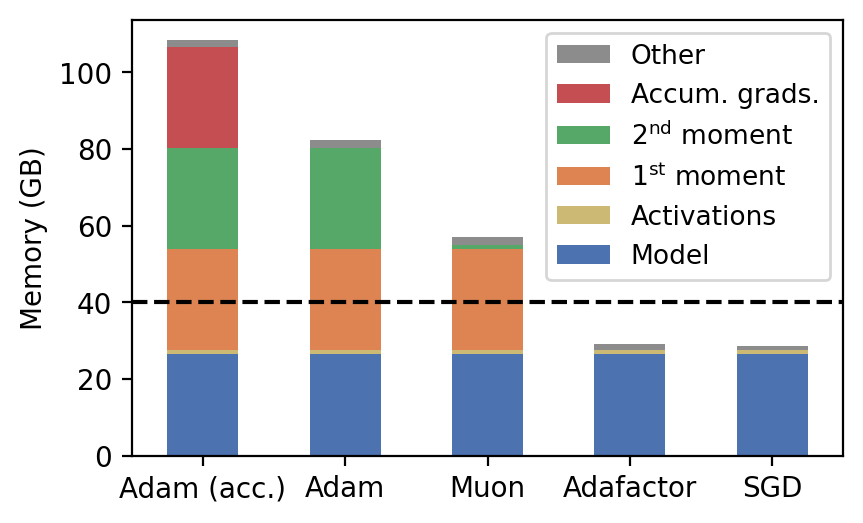

In [8]:
fig, ax = plt.subplots(figsize=(4.2, 2.5), layout='constrained')
# fig, ax = plt.subplots(figsize=(5, 3.5), layout='constrained')
# colors = ["#4C9AC9", "#FF7F4C", "#85B8A2", "#F2B87D"]
colors = np.array(sns.color_palette('deep'))[[0, 8, 1, 2, 3, 7]]
df_memory.plot.bar(rot=0, stacked=True, ax=ax, color=colors)
# ax.axhline(2*n_param / 10**9, ls='--', color='black')
ax.axhline(40, ls='--', color='black')
# ax.annotate('NVIDIA A100', (3.44, 42))
# ax.annotate('NVIDIA A100', (-0.46, 42), ha='left')
ax.set_ylabel('Memory (GB)')

# legend in reverse order
handles, labels = ax.get_legend_handles_labels()
labels = [label.replace('1st', r'1$^{\mathregular{st}}$').replace('2nd', r'2$^{\mathregular{nd}}$') for label in labels]
# ax.legend(*zip(*[(handles[i], labels[i]) for i in reversed(range(len(labels)))]))
ax.legend(list(reversed(handles)), list(reversed(labels)), prop={'size': 9.5})

# ax.set_title('GPT3 (13B)')
# plt.savefig('plots/memory_optimizers.pdf')
plt.show()

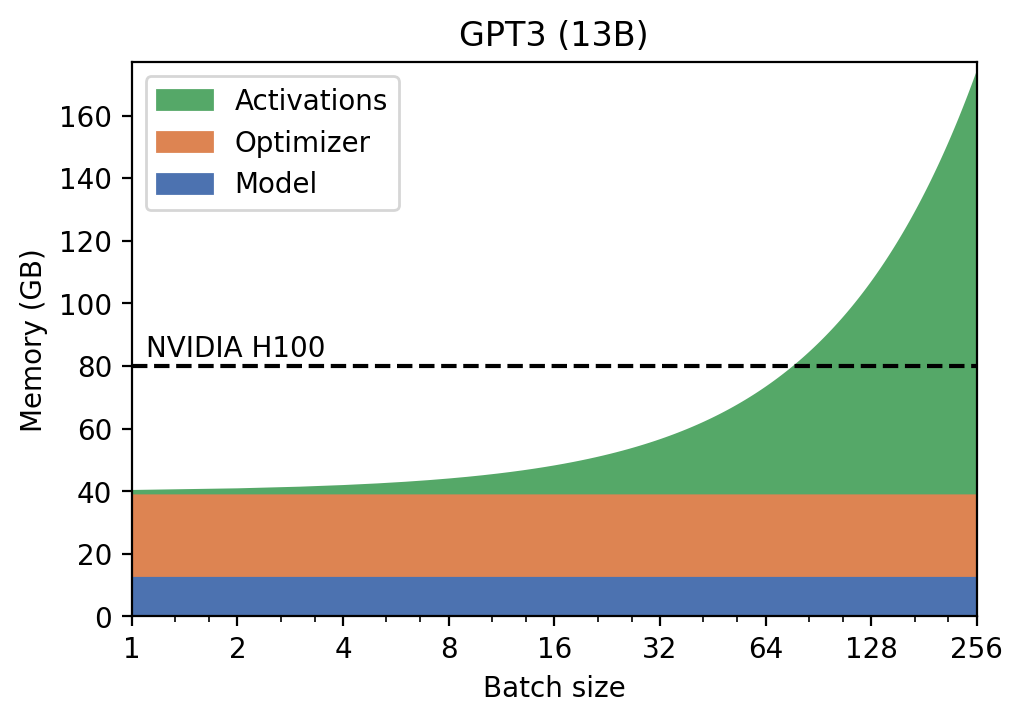

In [9]:
# batch size vs memory
bs = 1+np.arange(256)
fig, ax =  plt.subplots(figsize=(5, 3.5), layout='constrained')
colors = sns.color_palette('deep')
prev = 0*bs
# ax.plot(bs, prev:=prev + n_param)
# ax.plot(bs, prev:=prev + 2*n_param)
# ax.plot(bs, prev:=prev + bs * activation_memory_per_bs)
ax.fill_between(bs, prev, prev:=prev + n_param, color=colors[0], label='Model')
ax.fill_between(bs, prev, prev:=prev + 2*n_param, color=colors[1], label='Optimizer')
ax.fill_between(bs, prev, prev:=prev + bs * activation_memory_per_bs, color=colors[2], label='Activations')
ax.axhline(80*10**9, color='black', ls='--')
ax.annotate('NVIDIA H100', (1.1, 83*10**9))
ax.set_xscale('log')
ax.set_xticks(ticks := 2**np.arange(9), ticks)
ax.set_xticks([sub*2**i for i in range(9) for sub in [1.33, 1.66]], ['' for i in range(2*9)], minor=True)
ax.set_yticks(10**9 * np.arange(0, 161, 20))
ax.yaxis.set_major_formatter(lambda x, pos: f'{x/10**9:.0f}')
ax.set_xlim([1, 256])
ax.set_ylim([0, 1.77e11])
ax.set_xlabel('Batch size')
ax.set_ylabel('Memory (GB)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(list(reversed(handles)), list(reversed(labels)))
ax.set_title('GPT3 (13B)')
# plt.savefig('plots/memory_vs_batch_size.pdf')
plt.show()